In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchvision matplotlib tensorboard

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import copy


In [ ]:
# Define data transformations
data_dir = '/content/drive/MyDrive/Characters/platecharacters'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    if model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        # Modify the final layer
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "vgg16":
        model_ft = models.vgg16(pretrained=use_pretrained)
        # Modify the final layer
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    return model_ft

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "resnet50"
num_classes = len(class_names)
feature_extract = True
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Set parameters for feature extraction
set_parameter_requires_grad(model_ft, feature_extract)

# Move the model to the device
model_ft = model_ft.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


In [ ]:
# K-Fold Cross-Validation with Logging
def k_fold_cross_validation(model_name, num_classes, feature_extract, k=1, num_epochs=20):
    kfold = KFold(n_splits=k, shuffle=True)

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    fold_history = [] # Initialize fold_history as a list of dictionaries
    fold = 0

    for train_idx, valid_idx in kfold.split(image_datasets['train']):
        print(f'Fold {fold}')

        fold_data = {'train_loss_history': [], 'val_loss_history': [],
                     'train_acc_history': [], 'val_acc_history': []} # Create a dictionary to store fold data


        # Creating dataloaders for this fold
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)

        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=16, sampler=train_subsampler, num_workers=4),
            'valid': DataLoader(image_datasets['train'], batch_size=16, sampler=valid_subsampler, num_workers=4)
        }

        model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
        model_ft = model_ft.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)

        best_model_wts = copy.deepcopy(model_ft.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model_ft.train()
                else:
                    model_ft.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer_ft.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model_ft(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer_ft.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].sampler)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model_ft.state_dict())

                # Store history for the current fold
                if phase == 'train':
                    fold_data['train_acc_history'].append(epoch_acc)
                    fold_data['train_loss_history'].append(epoch_loss)
                else:
                    fold_data['val_acc_history'].append(epoch_acc)
                    fold_data['val_loss_history'].append(epoch_loss)


        model_ft.load_state_dict(best_model_wts)
        fold_history.append(fold_data)  # Append the current fold's data to fold_history
        fold += 1

    return model_ft, fold_history
# Perform k-fold cross-validation
model_ft,fold_history = k_fold_cross_validation(model_name, num_classes, feature_extract, k=5, num_epochs=20)

# Save the final model to Google Drive
model_save_path = '/content/drive/MyDrive/ResNet50_OCR_kfold1.pth'
torch.save(model_ft.state_dict(), model_save_path)

Fold 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/19
----------
train Loss: 1.6691 Acc: 0.5281
valid Loss: 0.4905 Acc: 0.8809
Epoch 1/19
----------
train Loss: 0.4731 Acc: 0.8752
valid Loss: 0.2153 Acc: 0.9338
Epoch 2/19
----------
train Loss: 0.3129 Acc: 0.9135
valid Loss: 0.1677 Acc: 0.9414
Epoch 3/19
----------
train Loss: 0.2553 Acc: 0.9234
valid Loss: 0.2243 Acc: 0.9244
Epoch 4/19
----------
train Loss: 0.2160 Acc: 0.9329
valid Loss: 0.1401 Acc: 0.9546
Epoch 5/19
----------
train Loss: 0.1935 Acc: 0.9409
valid Loss: 0.1259 Acc: 0.9527
Epoch 6/19
----------
train Loss: 0.1858 Acc: 0.9414
valid Loss: 0.1075 Acc: 0.9584
Epoch 7/19
----------
train Loss: 0.1946 Acc: 0.9437
valid Loss: 0.1088 Acc: 0.9565
Epoch 8/19
----------
train Loss: 0.1553 Acc: 0.9532
valid Loss: 0.1214 Acc: 0.9527
Epoch 9/19
----------
train Loss: 0.1461 Acc: 0.9532
valid Loss: 0.0984 Acc: 0.9641
Epoch 10/19
----------
train Loss: 0.1371 Acc: 0.9574
valid Loss: 0.0961 Acc: 0.9698
Epoch 11/19
----------
train Loss: 0.1557 Acc: 0.9489
valid Loss: 0.0683 Ac

In [ ]:
# Specify the file path where you want to save the fold_history data
save_path = '/content/drive/MyDrive/fold_history.pth'
torch.save(fold_history, save_path)

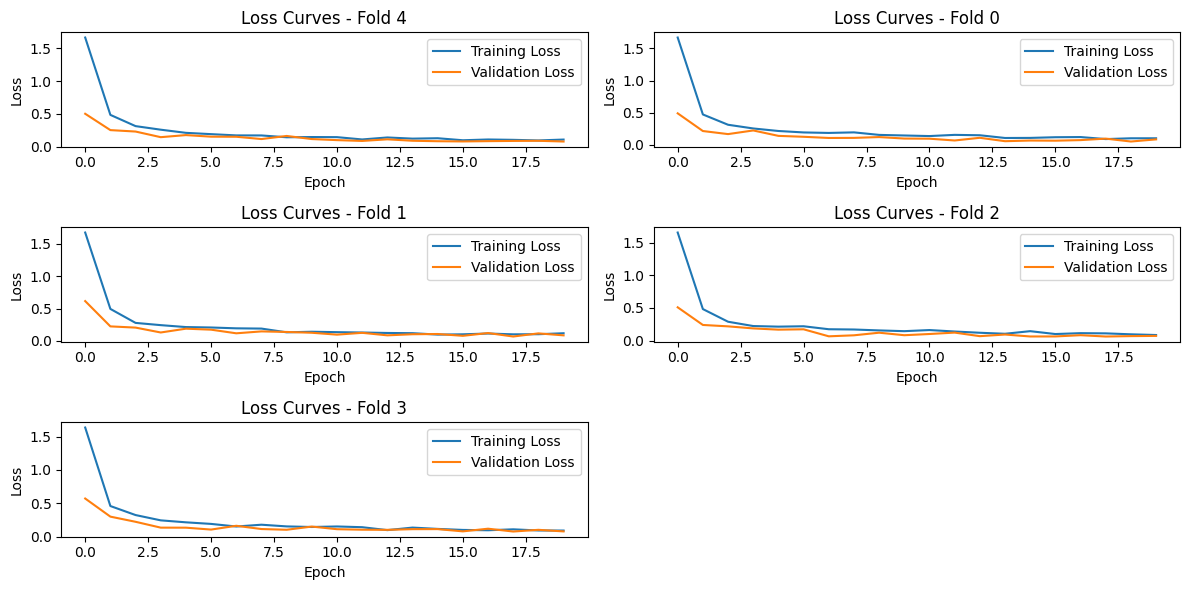

In [ ]:
import matplotlib.pyplot as plt

# Plotting the curves for fold 4 only
fold_index = 4  # Specify the fold index you want to plot

plt.figure(figsize=(12, 6))

# Plot for fold 4
plt.subplot(3, 2, 1)
plt.plot(fold_history[fold_index]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[fold_index]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {fold_index}')

# Plot for fold 0
plt.subplot(3, 2, 2)
plt.plot(fold_history[0]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[0]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {0}')

# Plot for fold 1
plt.subplot(3, 2, 3)
plt.plot(fold_history[1]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[1]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {1}')

# Plot for fold 2
plt.subplot(3, 2, 4)
plt.plot(fold_history[2]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[2]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {2}')

# Plot for fold 3
plt.subplot(3, 2, 5)
plt.plot(fold_history[3]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[3]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {3}')

plt.tight_layout()  # Adjust subplots to fit in figure area.
plt.show()


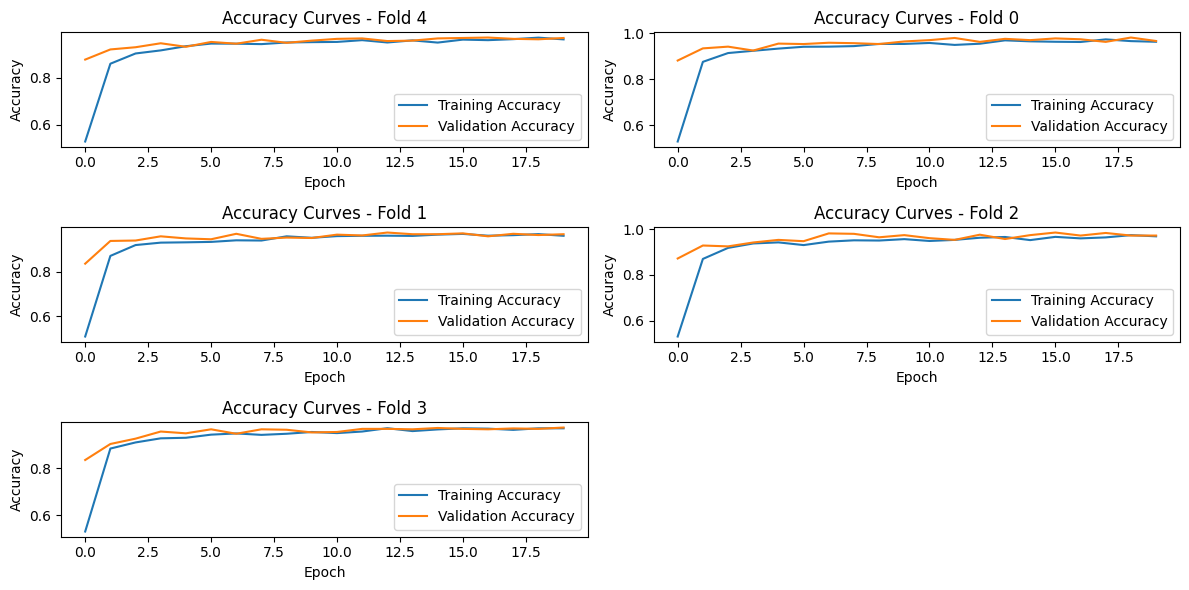

In [ ]:
# Plotting the curves for fold 4 only
fold_index = 4  # Specify the fold index you want to plot

plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[fold_index]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[fold_index]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {fold_index}')

plt.subplot(3, 2, 2)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[0]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[0]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {0}')

plt.subplot(3, 2, 3)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[1]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[1]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {1}')

plt.subplot(3, 2, 4)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[2]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[2]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {2}')


plt.subplot(3, 2, 5)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[3]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[3]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {3}')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


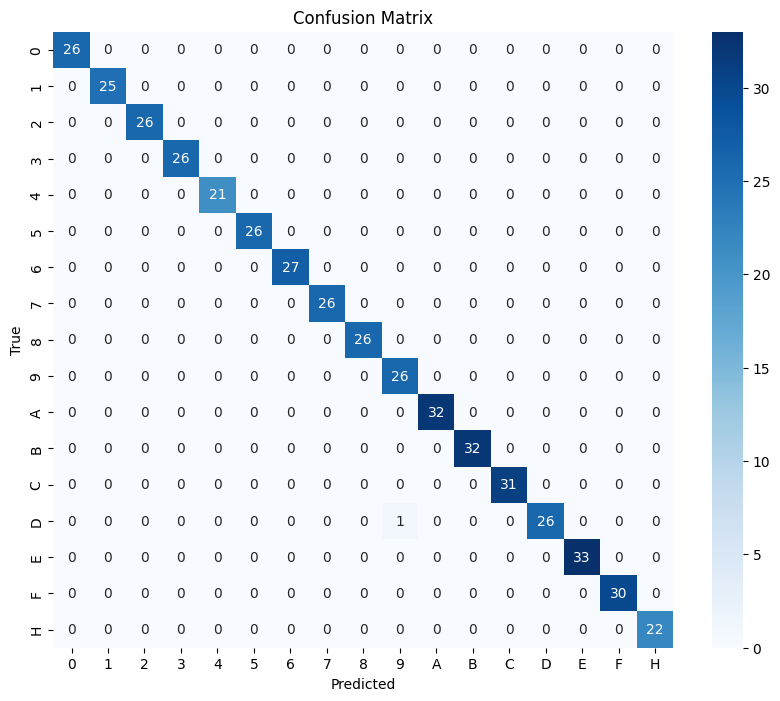

Accuracy: 0.9978
Precision: 0.9979
Recall: 0.9978


In [ ]:
# Test the model on the test dataset and create confusion matrix
test_loader = DataLoader(image_datasets['valid'], batch_size=16, shuffle=False, num_workers=4)
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


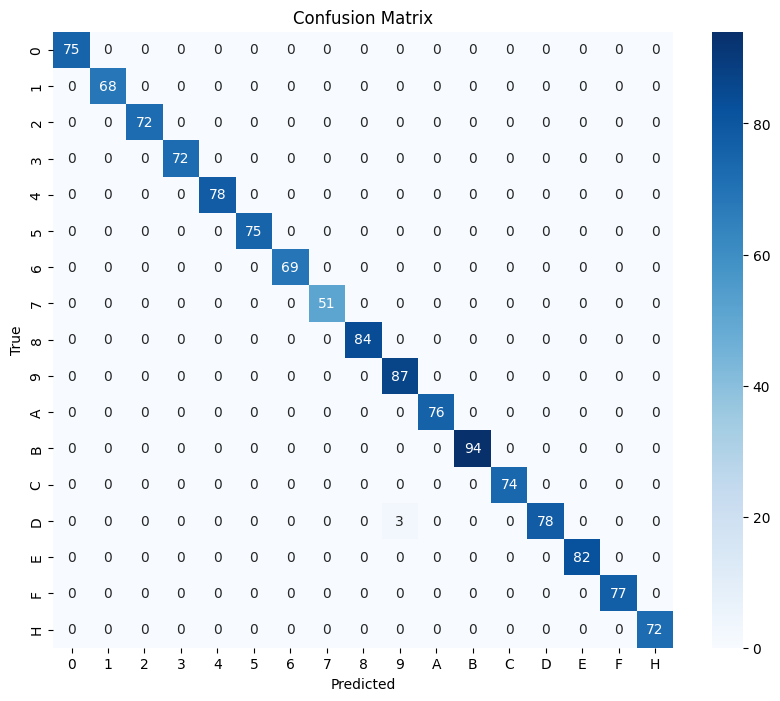

Accuracy: 0.9977
Precision: 0.9977
Recall: 0.9977


In [ ]:
# Test the model on the test dataset and create confusion matrix
test_loader = DataLoader(image_datasets['test'], batch_size=16, shuffle=False, num_workers=4)
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')



In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    if model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
    elif model_name == "vgg16":
        model_ft = models.vgg16(pretrained=use_pretrained)
        # Modify the final layer
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    return model_ft

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "alexnet"
num_classes = len(class_names)
feature_extract = True
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Set parameters for feature extraction
set_parameter_requires_grad(model_ft, feature_extract)

# Move the model to the device
model_ft = model_ft.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 72.4MB/s]


In [ ]:
# K-Fold Cross-Validation with Logging
def k_fold_cross_validation(model_name, num_classes, feature_extract, k=5, num_epochs=20):
    kfold = KFold(n_splits=k, shuffle=True)

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    fold_history = [] # Initialize fold_history as a list of dictionaries
    fold = 0

    for train_idx, valid_idx in kfold.split(image_datasets['train']):
        print(f'Fold {fold}')

        fold_data = {'train_loss_history': [], 'val_loss_history': [],
                     'train_acc_history': [], 'val_acc_history': []} # Create a dictionary to store fold data


        # Creating dataloaders for this fold
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)

        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=16, sampler=train_subsampler, num_workers=4),
            'valid': DataLoader(image_datasets['train'], batch_size=16, sampler=valid_subsampler, num_workers=4)
        }

        model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
        model_ft = model_ft.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)

        best_model_wts = copy.deepcopy(model_ft.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model_ft.train()
                else:
                    model_ft.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer_ft.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model_ft(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer_ft.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].sampler)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model_ft.state_dict())

                # Store history for the current fold
                if phase == 'train':
                    fold_data['train_acc_history'].append(epoch_acc)
                    fold_data['train_loss_history'].append(epoch_loss)
                else:
                    fold_data['val_acc_history'].append(epoch_acc)
                    fold_data['val_loss_history'].append(epoch_loss)


        model_ft.load_state_dict(best_model_wts)
        fold_history.append(fold_data)  # Append the current fold's data to fold_history
        fold += 1

    return model_ft, fold_history
# Perform k-fold cross-validation
model_ft,fold_history = k_fold_cross_validation(model_name, num_classes, feature_extract, k=5, num_epochs=20)

# Save the final model to Google Drive
model_save_path = '/content/drive/MyDrive/Alexa_OCR_kfold.pth'
torch.save(model_ft.state_dict(), model_save_path)

Fold 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/19
----------
train Loss: 2.1496 Acc: 0.4629
valid Loss: 0.7915 Acc: 0.7410
Epoch 1/19
----------
train Loss: 0.7490 Acc: 0.7702
valid Loss: 0.5262 Acc: 0.8488
Epoch 2/19
----------
train Loss: 0.5181 Acc: 0.8411
valid Loss: 0.4615 Acc: 0.8715
Epoch 3/19
----------
train Loss: 0.4083 Acc: 0.8652
valid Loss: 0.3333 Acc: 0.8866
Epoch 4/19
----------
train Loss: 0.3622 Acc: 0.8832
valid Loss: 0.2988 Acc: 0.8941
Epoch 5/19
----------
train Loss: 0.3083 Acc: 0.8941
valid Loss: 0.2292 Acc: 0.9206
Epoch 6/19
----------
train Loss: 0.2793 Acc: 0.9121
valid Loss: 0.1927 Acc: 0.9225
Epoch 7/19
----------
train Loss: 0.2561 Acc: 0.9168
valid Loss: 0.2774 Acc: 0.8979
Epoch 8/19
----------
train Loss: 0.2871 Acc: 0.9035
valid Loss: 0.1829 Acc: 0.9490
Epoch 9/19
----------
train Loss: 0.2607 Acc: 0.9111
valid Loss: 0.1901 Acc: 0.9244
Epoch 10/19
----------
train Loss: 0.2471 Acc: 0.9220
valid Loss: 0.2122 Acc: 0.9338
Epoch 11/19
----------
train Loss: 0.1934 Acc: 0.9376
valid Loss: 0.1840 Ac